In [1]:
import os, torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HOME"] = "/kaggle/working/hf_cache"

DATA_DIR   = "/kaggle/input/uit-data-nhatnam6"
TRAIN_XLSX = os.path.join(DATA_DIR, "train_nor_811.xlsx")
VALID_XLSX = os.path.join(DATA_DIR, "valid_nor_811.xlsx")
TEST_XLSX  = os.path.join(DATA_DIR, "test_nor_811.xlsx")

OUT_DIR   = "/kaggle/working/outputs_xlmr_vsmec"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
BEST_DIR  = os.path.join(OUT_DIR, "best_model")
CACHE_DIR = os.path.join(OUT_DIR, "cache")  # vẫn tạo để dùng nếu cần cache khác

for d in [OUT_DIR, PLOTS_DIR, BEST_DIR, CACHE_DIR]:
    os.makedirs(d, exist_ok=True)

print("GPUs:", torch.cuda.device_count())
print("Files exist:", os.path.exists(TRAIN_XLSX), os.path.exists(VALID_XLSX), os.path.exists(TEST_XLSX))


GPUs: 2
Files exist: True True True


In [2]:
import re, json, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import Dataset

from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, set_seed
)
# from transformers import EarlyStoppingCallback  # nếu muốn thêm early stopping


2025-12-22 08:39:14.634773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766392754.817672      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766392754.868294      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766392755.289208      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766392755.289243      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766392755.289245      55 computation_placer.cc:177] computation placer alr

In [3]:
# ================== Regex & chuẩn hoá ==================
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MULTISPACE_RE = re.compile(r"\s+")

def normalize_text(text: str) -> str:
    if text is None:
        return ""
    text = unicodedata.normalize("NFC", str(text))
    text = URL_RE.sub(" <url> ", text)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text


# ================== Đọc file & detect cột ==================
def read_xlsx(path: str) -> pd.DataFrame:
    return pd.read_excel(path, engine="openpyxl")

def detect_cols(df: pd.DataFrame):
    cols_lower = [c.lower() for c in df.columns]
    text_candidates  = ["sentence","text","comment","content","review","utterance"]
    label_candidates = ["emotion","label","labels","class","category"]

    text_col = next((df.columns[i] for i,c in enumerate(cols_lower) if c in text_candidates), None)
    label_col = next((df.columns[i] for i,c in enumerate(cols_lower) if c in label_candidates), None)

    if text_col is None:
        obj_cols = [c for c in df.columns if df[c].dtype == "object"]
        avg_len = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
        text_col = max(avg_len, key=avg_len.get)

    if label_col is None:
        cand = []
        for c in df.columns:
            if df[c].dtype == "object":
                nunq = df[c].nunique()
                if 2 <= nunq <= 50:
                    cand.append((c, nunq))
        label_col = sorted(cand, key=lambda x: x[1])[0][0]

    return text_col, label_col

def prep_df(df: pd.DataFrame, text_col: str, label_col: str) -> pd.DataFrame:
    out = df[[text_col, label_col]].copy()
    out.columns = ["text", "label"]
    out["text"]  = out["text"].astype(str)
    out["label"] = out["label"].astype(str)
    return out

In [4]:
# ================== Plot phân bố nhãn ==================
def plot_label_distribution(df: pd.DataFrame, split_name: str, label_list, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    counts = df["label"].value_counts().reindex(label_list, fill_value=0)

    plt.figure(figsize=(8, 4))
    plt.bar(counts.index, counts.values)
    plt.title(f"Label distribution - {split_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    out_path = os.path.join(out_dir, f"label_dist_{split_name}.png")
    plt.savefig(out_path)
    plt.show()
    plt.close()

    print(f"✅ Saved label distribution for {split_name} to:", out_path)


# ================== Metrics cho Trainer ==================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "macro_f1": float(f1_score(labels, preds, average="macro", zero_division=0)),
        "weighted_f1": float(f1_score(labels, preds, average="weighted", zero_division=0)),
    }


# ================== Plot loss / metrics ==================
def plot_curves(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    train_steps, train_loss = [], []
    eval_epochs, eval_loss = [], []
    eval_acc, eval_macro, eval_weighted = [], [], []

    for item in log_history:
        if "loss" in item and "eval_loss" not in item:
            train_steps.append(item.get("step", len(train_steps)+1))
            train_loss.append(item["loss"])
        if "eval_loss" in item:
            eval_epochs.append(item.get("epoch", len(eval_epochs)+1))
            eval_loss.append(item["eval_loss"])
            eval_acc.append(item.get("eval_accuracy"))
            eval_macro.append(item.get("eval_macro_f1"))
            eval_weighted.append(item.get("eval_weighted_f1"))

    # Training loss
    plt.figure()
    if train_loss:
        plt.plot(train_steps, train_loss, label="train_loss")
    plt.xlabel("step"); plt.ylabel("loss"); plt.title("Training loss")
    plt.legend(); plt.tight_layout()
    train_loss_path = os.path.join(out_dir, "train_loss.png")
    plt.savefig(train_loss_path)
    plt.show()
    plt.close()

    # Eval loss
    plt.figure()
    if eval_loss:
        plt.plot(eval_epochs, eval_loss, label="eval_loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Eval loss")
    plt.legend(); plt.tight_layout()
    eval_loss_path = os.path.join(out_dir, "eval_loss.png")
    plt.savefig(eval_loss_path)
    plt.show()
    plt.close()

    # Eval metrics
    plt.figure()
    if any(v is not None for v in eval_acc):
        plt.plot(eval_epochs, eval_acc, label="eval_accuracy")
    if any(v is not None for v in eval_macro):
        plt.plot(eval_epochs, eval_macro, label="eval_macro_f1")
    if any(v is not None for v in eval_weighted):
        plt.plot(eval_epochs, eval_weighted, label="eval_weighted_f1")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Eval metrics")
    plt.legend(); plt.tight_layout()
    eval_metrics_path = os.path.join(out_dir, "eval_metrics.png")
    plt.savefig(eval_metrics_path)
    plt.show()
    plt.close()


# ================== Confusion matrix ==================
def plot_confmat_normalized(y_true, y_pred, labels, out_path):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(8,8))
    disp.plot(values_format=".2f", cmap=None, ax=plt.gca(), colorbar=True)
    plt.title("Normalized Confusion Matrix (normalize=true)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()


# ================== Per-class F1 ==================
def plot_per_class_f1(y_true, y_pred, labels, out_path):
    f1s = f1_score(y_true, y_pred, average=None, zero_division=0)
    plt.figure(figsize=(10,4))
    plt.bar(labels, f1s)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.title("Per-class F1 (test)")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()

In [5]:
# ================== Hàm infer 1 câu cho XLM-R ==================
@torch.inference_mode()
def infer_xlmr(text, model, tokenizer, id2label, max_length=128, device=None):
    model.eval()
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    clean = normalize_text(text)
    inp = tokenizer(clean, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    out = model(**inp)
    probs = torch.softmax(out.logits, dim=-1).squeeze(0).detach().cpu().numpy()
    pred_id = int(np.argmax(probs))
    return {
        "input": text,
        "normalized": clean,
        "pred_label": id2label[pred_id],
        "probs": {id2label[i]: float(probs[i]) for i in range(len(probs))}
    }


# ================== Hàm in các mẫu dự đoán sai ==================
def check_wrong(df: pd.DataFrame, n: int = 20, show_seg: bool = False, random: bool = False):
    """
    In ra các mẫu dự đoán sai theo format:
    <text>
    Predicted: (X) --vs-- Real label: (Y)
    --------------------------------------------------
    (giữ nguyên style như pipeline PhoBERT; ở đây show_seg sẽ dùng 'text' vì không có text_seg)
    """
    wrong = df[df["is_correct"] == False]

    if wrong.empty:
        print("✅ Không có mẫu nào bị dự đoán sai.")
        return

    if random:
        wrong = wrong.sample(min(n, len(wrong)), random_state=42)
    else:
        wrong = wrong.head(n)

    for _, row in wrong.iterrows():
        # Pipeline XLM-R không có text_seg, nên luôn dùng text gốc
        text_show = row.get("text", "")
        print(text_show)
        print(f"Predicted: ({row['pred_label']}) --vs-- Real label: ({row['label']})")
        print("-" * 50)


Detected columns -> text: Sentence | label: Emotion
Sizes: 5548 686 693


,text,label
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment


Labels: ['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise']


,text,label,labels,text_clean
0,cho mình xin bài nhạc tên là gì với ạ,Other,4,cho mình xin bài nhạc tên là gì với ạ
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust,1,lo học đi . yêu đương lol gì hay lại thích học...
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment,2,uớc gì sau này về già vẫn có thể như cụ này :))
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment,2,mỗi lần có video của con là cứ coi đi coi lại ...


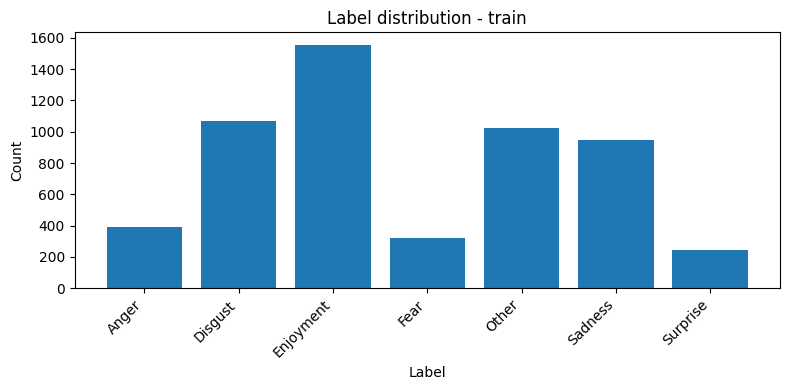

✅ Saved label distribution for train to: /kaggle/working/outputs_xlmr_vsmec/plots/label_dist_train.png


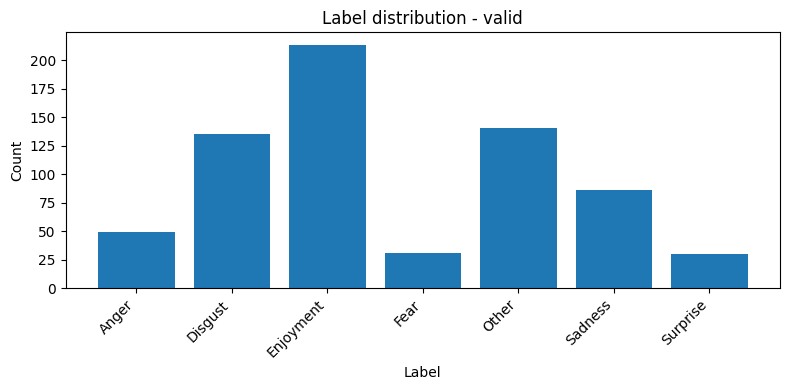

✅ Saved label distribution for valid to: /kaggle/working/outputs_xlmr_vsmec/plots/label_dist_valid.png


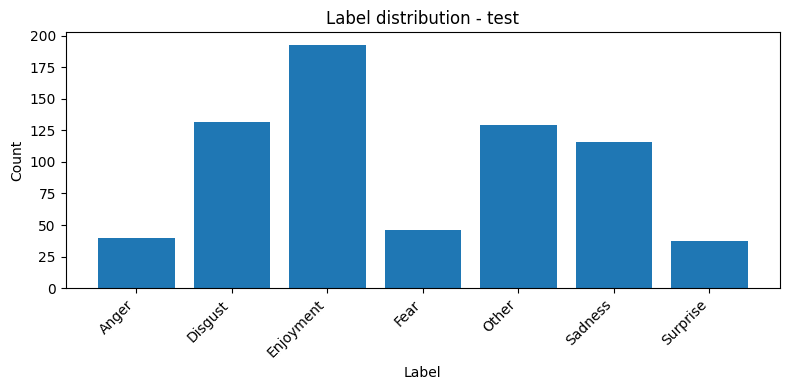

✅ Saved label distribution for test to: /kaggle/working/outputs_xlmr_vsmec/plots/label_dist_test.png


In [6]:
# ================== Đọc dữ liệu gốc ==================
train_raw = read_xlsx(TRAIN_XLSX)
valid_raw = read_xlsx(VALID_XLSX)
test_raw  = read_xlsx(TEST_XLSX)

# Tự động detect cột text / label
text_col, label_col = detect_cols(train_raw)
print("Detected columns -> text:", text_col, "| label:", label_col)

# Chuẩn hoá về 2 cột: text, label
train_df = prep_df(train_raw, text_col, label_col)
valid_df = prep_df(valid_raw, text_col, label_col)
test_df  = prep_df(test_raw,  text_col, label_col)

print("Sizes:", len(train_df), len(valid_df), len(test_df))
display(train_df.head())

# Mapping nhãn
label_list = sorted(train_df["label"].unique().tolist())
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

for df in [train_df, valid_df, test_df]:
    df["labels"] = df["label"].map(label2id)

print("Labels:", label_list)

# ================== Chuẩn hoá text cho XLM-R ==================
def preprocess_text_column(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["text_clean"] = df["text"].apply(normalize_text)
    return df

train_df = preprocess_text_column(train_df)
valid_df = preprocess_text_column(valid_df)
test_df  = preprocess_text_column(test_df)

display(train_df.head())

# ================== Plot phân bố nhãn ==================
plot_label_distribution(train_df, "train", label_list, PLOTS_DIR)
plot_label_distribution(valid_df, "valid", label_list, PLOTS_DIR)
plot_label_distribution(test_df,  "test",  label_list, PLOTS_DIR)

In [7]:
# ================== Tokenizer & Dataset cho XLM-R ==================
MODEL_NAME = "xlm-roberta-base"
MAX_LEN = 128  # để so sánh fair với PhoBERT

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.padding_side = "right"

ds_train = Dataset.from_pandas(train_df[["text_clean","labels"]], preserve_index=False)
ds_valid = Dataset.from_pandas(valid_df[["text_clean","labels"]], preserve_index=False)
ds_test  = Dataset.from_pandas(test_df[["text_clean","labels"]],  preserve_index=False)

def tok_map(batch):
    return tokenizer(batch["text_clean"], truncation=True, max_length=MAX_LEN)

ds_train_tok = ds_train.map(tok_map, batched=True, remove_columns=["text_clean"], desc="Tokenize train")
ds_valid_tok = ds_valid.map(tok_map, batched=True, remove_columns=["text_clean"], desc="Tokenize valid")
ds_test_tok  = ds_test.map(tok_map,  batched=True, remove_columns=["text_clean"], desc="Tokenize test")

collator = DataCollatorWithPadding(tokenizer=tokenizer)
ds_train_tok

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenize train:   0%|          | 0/5548 [00:00<?, ? examples/s]

Tokenize valid:   0%|          | 0/686 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/693 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5548
})

In [8]:
# ================== Hyperparams XLM-R ==================
SEED = 42
set_seed(SEED)

EPOCHS = 20
PER_DEVICE_BS = 8
GRAD_ACCUM = 4
LR = 2e-5

WEIGHT_DECAY = 0.01
LABEL_SMOOTH = 0.10
DROPOUT = 0.10
WARMUP_RATIO = 0.10
MAX_GRAD_NORM = 1.0

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    label2id=label2id,
    id2label=id2label,
    problem_type="single_label_classification",
)
if hasattr(config, "hidden_dropout_prob"):
    config.hidden_dropout_prob = DROPOUT
if hasattr(config, "attention_probs_dropout_prob"):
    config.attention_probs_dropout_prob = DROPOUT
if hasattr(config, "classifier_dropout") and config.classifier_dropout is not None:
    config.classifier_dropout = DROPOUT

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    overwrite_output_dir=True,

    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BS,
    per_device_eval_batch_size=PER_DEVICE_BS,
    gradient_accumulation_steps=GRAD_ACCUM,

    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="linear",

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    logging_strategy="steps",
    logging_steps=50,

    label_smoothing_factor=LABEL_SMOOTH,
    max_grad_norm=MAX_GRAD_NORM,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED,

    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_valid_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # nếu muốn
)

print("Trainer ready (XLM-R).")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_55/805701112.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready (XLM-R).


In [9]:

# ================== Train ==================
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.911200,1.753240,0.349854,0.144779,0.241445
2,1.648600,1.424289,0.529155,0.326369,0.478874
3,1.372300,1.302197,0.586006,0.432595,0.559846
4,1.267900,1.317196,0.590379,0.435123,0.553559
5,1.159800,1.323799,0.600583,0.487510,0.587333
6,1.049900,1.280537,0.628280,0.522343,0.612877
7,0.950400,1.325855,0.622449,0.560590,0.621748
8,0.897500,1.376833,0.604956,0.532937,0.601893
9,0.807300,1.383608,0.612245,0.549485,0.614132
10,0.761500,1.448200,0.599125,0.536435,0.598793


TrainOutput(global_step=1740, training_loss=0.8882125898339283, metrics={'train_runtime': 2341.1251, 'train_samples_per_second': 47.396, 'train_steps_per_second': 0.743, 'total_flos': 2693305112185200.0, 'train_loss': 0.8882125898339283, 'epoch': 20.0})

In [10]:
# ================== Predict trên test ==================
pred = trainer.predict(ds_test_tok)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print("=== TEST SUMMARY (XLM-R) ===")
print("Accuracy    :", round(accuracy_score(y_true, y_pred), 4))
print("Macro F1    :", round(f1_score(y_true, y_pred, average="macro", zero_division=0), 4))
print("Weighted F1 :", round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 4))

print("\n=== CLASSIFICATION REPORT (XLM-R) ===")
print(classification_report(y_true, y_pred, target_names=label_list, digits=4, zero_division=0))

# Gắn dự đoán vào test_df để phân tích lỗi
test_df["pred_id"] = y_pred
test_df["pred_label"] = test_df["pred_id"].map(id2label)
test_df["is_correct"] = test_df["pred_label"] == test_df["label"]

print("\n=== VÍ DỤ DỰ ĐOÁN SAI (test, XLM-R) ===")
check_wrong(test_df, n=20, show_seg=False, random=False)

=== TEST SUMMARY (XLM-R) ===
Accuracy    : 0.6335
Macro F1    : 0.6073
Weighted F1 : 0.6332

=== CLASSIFICATION REPORT (XLM-R) ===
              precision    recall  f1-score   support

       Anger     0.4545    0.5000    0.4762        40
     Disgust     0.6250    0.4924    0.5508       132
   Enjoyment     0.7302    0.7150    0.7225       193
        Fear     0.6078    0.6739    0.6392        46
       Other     0.5310    0.5969    0.5620       129
     Sadness     0.7167    0.7414    0.7288       116
    Surprise     0.5500    0.5946    0.5714        37

    accuracy                         0.6335       693
   macro avg     0.6022    0.6163    0.6073       693
weighted avg     0.6372    0.6335    0.6332       693


=== VÍ DỤ DỰ ĐOÁN SAI (test, XLM-R) ===
người ta có bạn bè nhìn vui thật
Predicted: (Enjoyment) --vs-- Real label: (Sadness)
--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Anger) --vs-- Real label: (Surprise)
----

In [11]:
# ================== Lưu model tốt nhất ==================
trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
with open(os.path.join(BEST_DIR, "labels.json"), "w", encoding="utf-8") as f:
    json.dump({"label_list": label_list, "label2id": label2id, "id2label": id2label},
              f, ensure_ascii=False, indent=2)

print("✅ Saved best XLM-R model to:", BEST_DIR)

✅ Saved best XLM-R model to: /kaggle/working/outputs_xlmr_vsmec/best_model


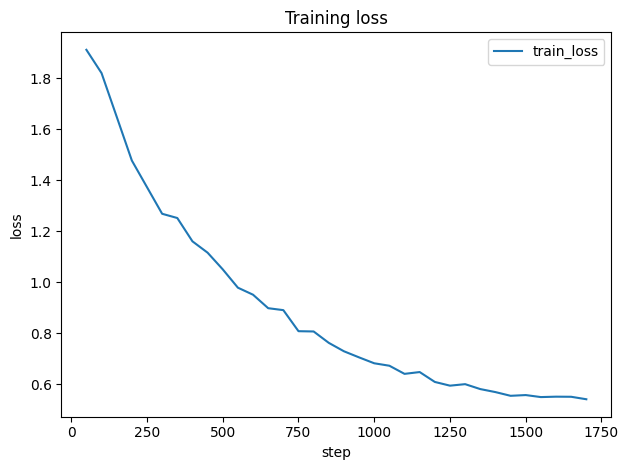

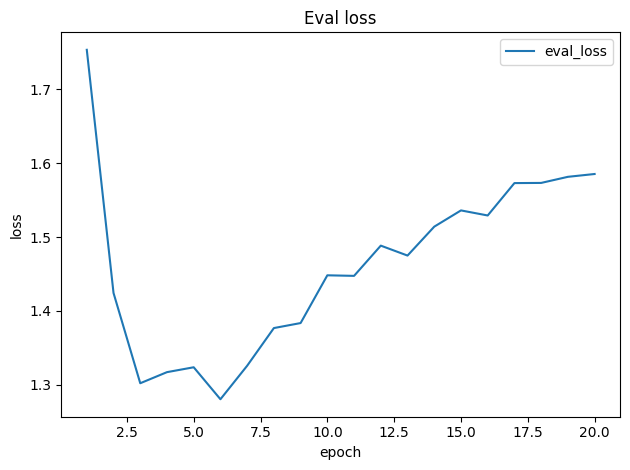

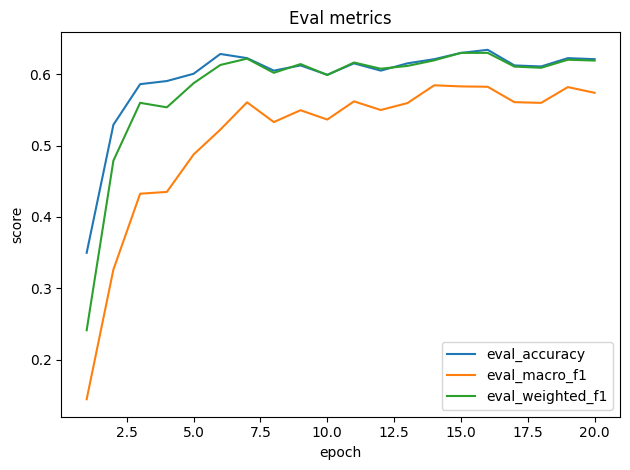

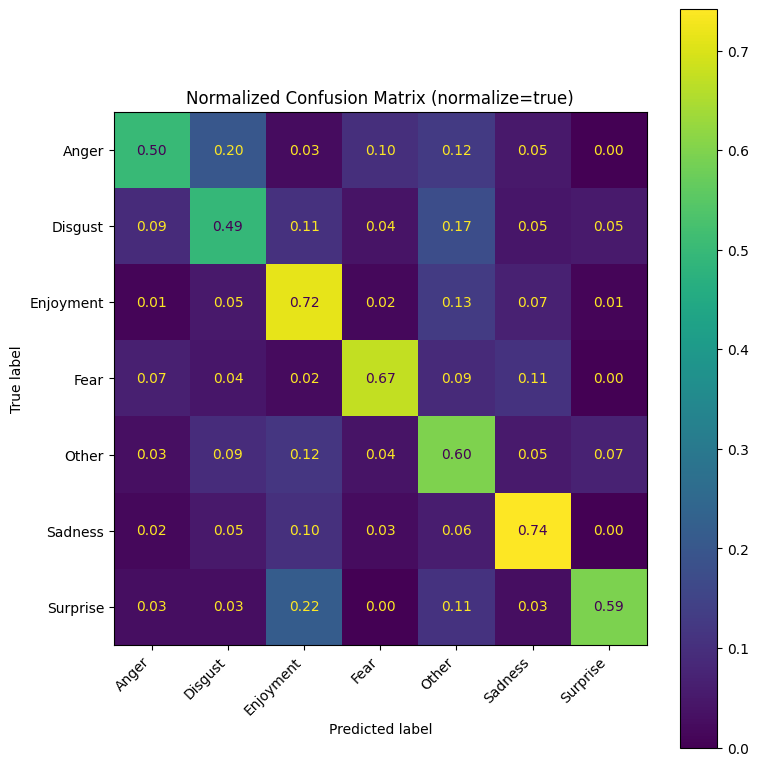

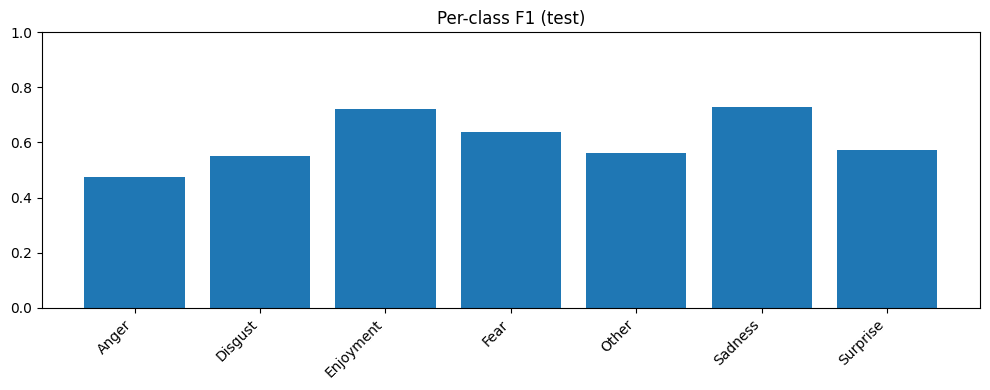

✅ Plots saved to: /kaggle/working/outputs_xlmr_vsmec/plots


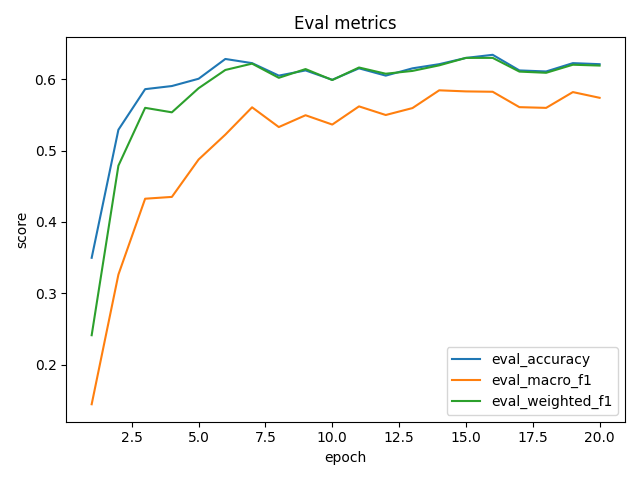

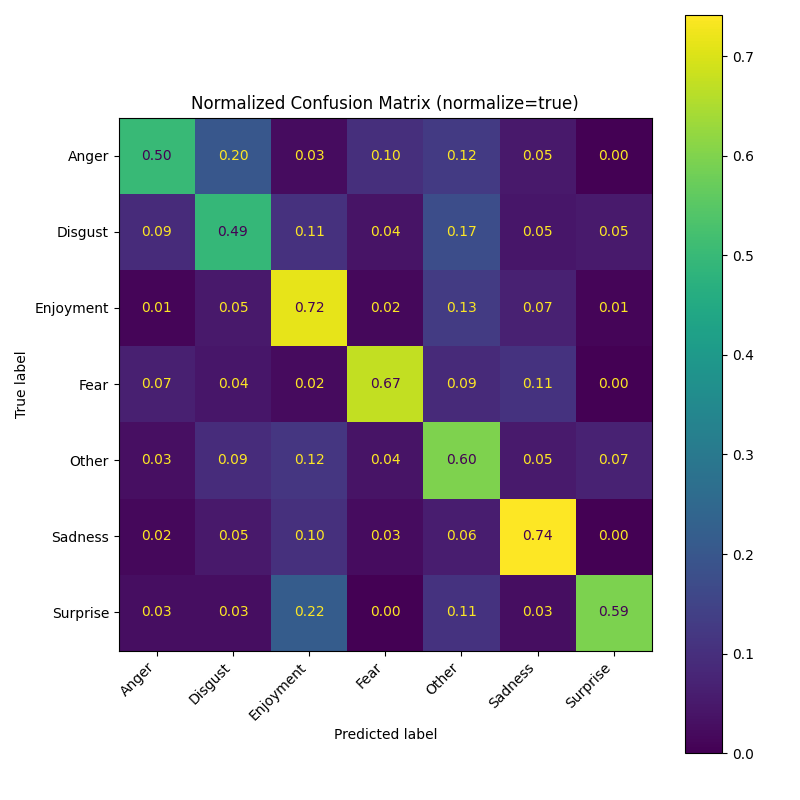

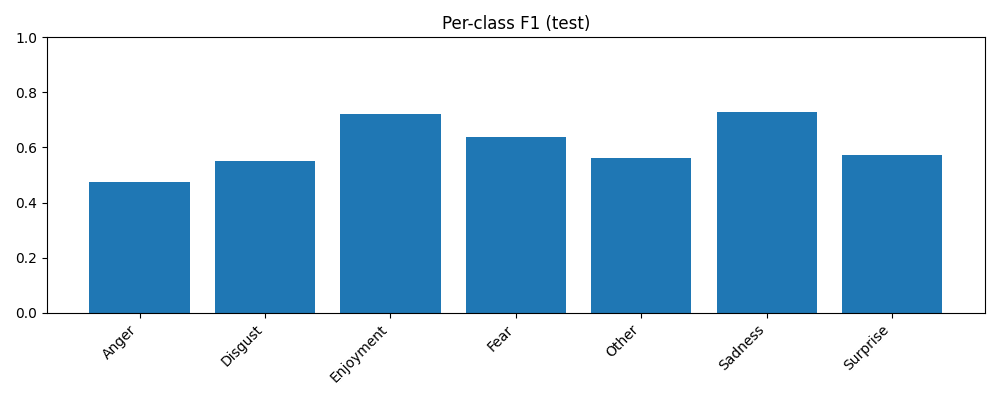

{
  "input": "phấn chấn lên nào bro, ở đây có ae, không phải lo",
  "normalized": "phấn chấn lên nào bro, ở đây có ae, không phải lo",
  "pred_label": "Enjoyment",
  "probs": {
    "Anger": 0.008862815797328949,
    "Disgust": 0.008222676813602448,
    "Enjoyment": 0.9087692499160767,
    "Fear": 0.029398702085018158,
    "Other": 0.020994015038013458,
    "Sadness": 0.0053915600292384624,
    "Surprise": 0.018360935151576996
  }
}


In [12]:
# ================== Vẽ & hiển thị các plot ==================
plot_curves(trainer.state.log_history, PLOTS_DIR)
plot_confmat_normalized(y_true, y_pred, label_list, os.path.join(PLOTS_DIR, "confmat_normalized.png"))
plot_per_class_f1(y_true, y_pred, label_list, os.path.join(PLOTS_DIR, "per_class_f1.png"))

print("✅ Plots saved to:", PLOTS_DIR)

from PIL import Image
from IPython.display import display

display(Image.open(os.path.join(PLOTS_DIR, "eval_metrics.png")))
display(Image.open(os.path.join(PLOTS_DIR, "confmat_normalized.png")))
display(Image.open(os.path.join(PLOTS_DIR, "per_class_f1.png")))

# ================== Demo infer ==================
device = "cuda" if torch.cuda.is_available() else "cpu"
trainer.model.to(device)

demo = infer_xlmr(
    "phấn chấn lên nào bro, ở đây có ae, không phải lo",
    trainer.model,
    tokenizer,
    id2label,
    max_length=MAX_LEN,
    device=device,
)
print(json.dumps(demo, ensure_ascii=False, indent=2))

In [13]:
# ================== Đóng gói model ==================
import shutil

print("BEST_DIR:", BEST_DIR)
zip_path = "/kaggle/working/xlmr_vsmec_best_model"
shutil.make_archive(zip_path, "zip", BEST_DIR)
print("✅ Đã tạo file:", zip_path + ".zip")

BEST_DIR: /kaggle/working/outputs_xlmr_vsmec/best_model
✅ Đã tạo file: /kaggle/working/xlmr_vsmec_best_model.zip
